In [557]:
from impala.dbapi import connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#
from tqdm import tqdm
from datetime import datetime,timedelta
#Geo data EDA
import descartes
from shapely.geometry import Point, Polygon
import geopandas as gpd
#Graph
import networkx as nx
##############
from sklearn.cluster import KMeans,DBSCAN

In [2]:
df_dv_trips = pd.read_csv('divvy_travel_hist.csv')

C:\Users\18066\Anaconda3\envs\Divvy\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (3,8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Feature Eng Objective
1. Columns are each station appeared during the subset sample
2. 

In [3]:
def Divvy_Graph_community(sample_df,detail_level = 1, group_by = None,show_plot=True,node_size = 10,figsize=(24,12)):
    assert group_by in ['station_id','Nbh_id','com_id'],"group by must be one of the following: 3:station_id',2:'Nbh_id',1:'com_id'"
    if group_by is None:
        if detail_level == 1:
            group_by = 'com_id'
        elif detail_level == 2:
            group_by = 'Nbh_id'
        elif detail_level == 3:
            group_by = 'station_id'
        else:
            assert False, "detail_level must be one of the following: integers, 3:station_id',2:'Nbh_id',1:'com_id'"
    FG = nx.Graph()#nx.from_pandas_edgelist(sample_df, source='start_station_id', target='end_station_id', edge_attr=True)
    edge_df = sample_df.groupby(['start_'+group_by,'end_'+group_by]).count()
    max_count = edge_df.start_lat.max()
    stations_start = sample_df.groupby('start_'+group_by)[['start_lat','start_lng']].mean() 
    stations_start_end = sample_df.groupby('end_'+group_by)[['end_lat','end_lng']].mean()
    station_eng = stations_start.copy()
    #Joining all stations
    for idx in set(stations_start_end.index).difference(set(stations_start.index)):
        row = stations_start_end.loc[idx]
        station_eng.loc[idx] = [row.end_lat,row.end_lng]
    #For each station, add a node and record it's cordinate 
    for id,row in station_eng.iterrows():
        FG.add_node(id,cord = (row.start_lng,row.start_lat))
    for source,target in edge_df.index:
        FG.add_edge(source,target,count = edge_df.loc[(source,target)].start_lat/(max_count/10))
    #Plotting
    if show_plot:
        nodes = FG.nodes(data=True)
        pos = {node:attr['cord'] for node, attr in nodes}
        edges = FG.edges(data=True)
        width = [attr['count'] for a,b, attr in edges]
        #plt.figure(figsize=figsize)
        nx.draw(FG,
                pos=pos,
                node_size=node_size,
                node_color='orange',
                width=width,
                arrows=True)
    return FG

In [6]:
Graph = Divvy_Graph_community(df_dv_trips,group_by = 'station_id',show_plot=False)

In [29]:
df_Station = {'station_id':[],'lng' : [], 'lat' : [], 'cord':[]}
Erros = []
eps = 0.1
for node_data in tqdm(Graph.nodes(data=True)):
    station_id = str(node_data[0])
    cord = node_data[1]['cord']
    lng = cord[0]
    lat = cord[1]
    if station_id not in df_Station['station_id']:
        df_Station['station_id'].append(station_id)
        df_Station['lng'].append(lng)
        df_Station['lat'].append(lat)
        df_Station['cord'].append(cord)
    else:
        row_idx = df_Station['station_id'].index(station_id)
        if np.linalg.norm(np.array(cord) - np.array(df_Station['cord'][row_idx])) > eps:
            print(f'For station {station_id},cord has mismatch:{cord}|{df_Station["cord"][row_idx]}')
            print('Norm:',np.linalg.norm(np.array(cord) - np.array(df_Station['cord'][row_idx])))
            print('\n')
            Erros.append(node_data)
            #When this happens,replace data with more precision
            total_precision_og = len(str(df_Station['cord'][row_idx][0])) + len(str(df_Station['cord'][row_idx][1]))
            total_precision_new = len(str(lng)) + len(str(lat))
            if total_precision_new > total_precision_og:
                print("Replace")
                #Replace original data with new ones:
                df_Station['lng'][row_idx] = lng
                df_Station['lat'][row_idx] = lat
                df_Station['cord'][row_idx] = cord

100%|██████████| 1854/1854 [00:00<00:00, 63918.33it/s]

For station 319,cord has mismatch:(-87.76884214285711, 41.93788928571428)|(-87.66592834190568, 41.932597432987755)
Norm: 0.10304976531535205


For station 322,cord has mismatch:(-87.71894999999999, 41.91991400000003)|(-87.59472487197337, 41.79958346077642)
Norm: 0.17294889737455799


For station 327,cord has mismatch:(-87.77966199999996, 41.94187571428574)|(-87.65381140704042, 41.92154036215417)
Norm: 0.12748293334632002


For station 335,cord has mismatch:(-87.72138692307693, 41.83934230769232)|(-87.61802113662463, 41.83138829506436)
Norm: 0.10367136598785814


For station 351,cord has mismatch:(-87.77320078431379, 41.92501980392158)|(-87.60661122149294, 41.80302326406423)
Norm: 0.20648302152478884


For station 352,cord has mismatch:(-87.77217375, 41.9104375)|(-87.57717219858148, 41.77351633232018)
Norm: 0.2382708778143765


For station 353,cord has mismatch:(-87.77748380952389, 41.93196452380954)|(-87.6743692552022, 42.01257464403058)
Norm: 0.13088392871170818


Replace
For station 

In [69]:
df_Station_temp = pd.DataFrame(df_Station)

In [63]:
#Map all ids to its name
df_id_name = df_dv_trips.groupby('start_station_id')[['start_station_id','start_station_name']].apply(lambda x: x)
df_id_name = df_id_name.drop_duplicates()

In [67]:
df_id_name['start_station_id'] = [str(i) for i in list(df_id_name['start_station_id'])]
df_id_name = df_id_name.drop_duplicates()

In [74]:
df_Station_complete = df_Station_temp.merge(df_id_name,left_on='station_id',right_on='start_station_id').drop(columns = ['start_station_id'],axis = 1)
df_Station_complete = df_Station_complete.rename(columns={'start_station_name':'station_name'})

## Next up, merge with hbh and community 

In [81]:
df_community = pd.read_csv('chicago_community_new.csv',index_col=0)

In [83]:
df_community.head()

neighborhood_name  neighborhood_number community_name  community_area_id  \
0       Rogers Park                  1.0    Rogers Park                  1   
1            Loyola                  1.1    Rogers Park                  1   
2        West Ridge                  2.0     West Ridge                  2   
3   Arcadia Terrace                  2.1     West Ridge                  2   
4           Nortown                  2.2     West Ridge                  2   

         lat        lng  
0  42.012629 -87.674588  
1  41.998948 -87.658259  
2  42.000580 -87.692577  
3  41.986850 -87.694398  
4  41.998367 -87.763145

In [84]:
#Calculate distance given one cord:
def get_closest_nbg_id(cord1):
    cord1 = np.array(cord1)
    dist = np.sum((df_community[['lat','lng']] - cord1)**2,axis =1)**0.5
    return float(df_community.iloc[dist.argmin()].neighborhood_number)

In [86]:
Nbh_ids = []
for idx_st,row_st in tqdm(df_Station_complete.iterrows()):
    cord = float(row_st['lat']), float(row_st['lng'])
    id = str(get_closest_nbg_id(cord))
    Nbh_ids.append(id)

1361it [00:01, 955.54it/s]


In [88]:
df_Station_complete['Nbh_id'] = Nbh_ids
df_Station_complete['com_id'] = df_Station_complete['Nbh_id'].apply(lambda x:x.split('.')[0])

In [97]:
df_Station_complete.head()

station_id        lng        lat                                      cord  \
0          2 -87.620527  41.876503   (-87.62052684219132, 41.87650284189418)   
1          3 -87.615373  41.867215   (-87.61537258521274, 41.86721537439574)   
2          4 -87.613335  41.856277   (-87.61333539799435, 41.85627738078977)   
3          5 -87.627707  41.874066  (-87.62770717196332, 41.874066196819705)   
4          6 -87.612807  41.886985  (-87.61280661461953, 41.886984755969536)   

             station_name Nbh_id com_id  
0     Buckingham Fountain   32.0     32  
1          Shedd Aquarium   33.3     33  
2          Burnham Harbor   33.3     33  
3  State St & Harrison St   32.2     32  
4          Dusable Harbor   32.1     32

# Use all station as features, calculate capacity

In [91]:
df_station_old = pd.read_csv('Divvy_Stations.csv')
df_station_old['ID'] = [str(id) for id in list(df_station_old['ID'])]

In [102]:
df_Station_final = df_Station_complete.merge(df_station_old[['ID','Total Docks','Docks in Service']],
                            left_on='station_id',right_on='ID',how='left')

<AxesSubplot:>

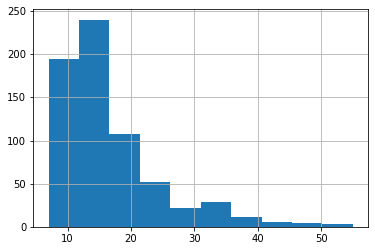

In [106]:
df_Station_final['Total Docks'].hist()

In [123]:
df_Station_final = df_Station_final.interpolate(method='pad').drop(columns=['Total Docks'],axis = 1 )

In [124]:
df_Station_final.to_csv('Divvy_stations_community.csv')

In [125]:
df_Station_final

station_id        lng        lat  \
0                2 -87.620527  41.876503   
1                3 -87.615373  41.867215   
2                4 -87.613335  41.856277   
3                5 -87.627707  41.874066   
4                6 -87.612807  41.886985   
...            ...        ...        ...   
1356  TA1309000066 -87.674237  41.969098   
1357  TA1309000067 -87.606615  41.803032   
1358        WL-008 -87.641080  41.867119   
1359        WL-011 -87.642739  41.880403   
1360        WL-012 -87.641203  41.883368   

                                          cord                   station_name  \
0      (-87.62052684219132, 41.87650284189418)            Buckingham Fountain   
1      (-87.61537258521274, 41.86721537439574)                 Shedd Aquarium   
2      (-87.61333539799435, 41.85627738078977)                 Burnham Harbor   
3     (-87.62770717196332, 41.874066196819705)         State St & Harrison St   
4     (-87.61280661461953, 41.886984755969536)                 Dusable Harbor   
...                                        ...                            ...   
1356     (-87.6742365525008, 41.9690978190076)  Ravenswood Ave & Lawrence Ave   
1357   (-87.60661523076966, 41.80303183589704)    Cottage Grove Ave & 51st St   
1358   (-87.64108027456139, 41.86711940029157)      Clinton St & Roosevelt Rd   
1359    (-87.64273862399185, 41.8804028265176)       Jefferson St & Monroe St   
1360   (-87.64120320829973, 41.88336784361322)   Clinton St & Washington Blvd   

     Nbh_id com_id  Docks in Service  
0      32.0     32              39.0  
1      33.3     33              55.0  
2      33.3     33              23.0  
3      32.2     32              23.0  
4      32.1     32              39.0  
...     ...    ...               ...  
1356    4.3      4              11.0  
1357   39.1     39              11.0  
1358   31.1     31              11.0  
1359   28.2     28              11.0  
1360   28.1     28              11.0  

[1361 rows x 8 columns]

# Start with a sample of a day

In [260]:
date = '2019-09-01'
trip_subset = df_dv_trips.query(f'date == "{date}"')[['started_at','ended_at','start_station_id','end_station_id','day_of_week']]
trip_subset['start_station_id'] = [str(id) for id in list(trip_subset['start_station_id'])]
trip_subset['end_station_id'] = [str(id) for id in list(trip_subset['end_station_id'])]
########################
#Change format for comparison
trip_subset['started_at'] = trip_subset.started_at.apply(
                        lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
trip_subset['ended_at'] = trip_subset.ended_at.apply(
                        lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
##################
#Merge with station to get docks info
trip_subset = trip_subset.merge(df_Station_final[['station_id','Nbh_id','com_id']],left_on='start_station_id',right_on='station_id')
trip_subset = trip_subset.rename(columns={'Nbh_id':'start_Nbh_id','com_id':'start_com_id'}).drop(columns = ['station_id'],axis = 1)
trip_subset = trip_subset.merge(df_Station_final[['station_id','Nbh_id','com_id']],left_on='end_station_id',right_on='station_id')
trip_subset = trip_subset.rename(columns={'Nbh_id':'end_Nbh_id','com_id':'end_com_id'}).drop(columns = ['station_id'],axis = 1)
################################################################
#Create subsets
trip_subset_starts = trip_subset[['started_at','start_station_id','start_Nbh_id','start_com_id']]
trip_subset_starts.insert(4,'Leaving',1)
trip_subset_starts = trip_subset_starts.rename(columns = {'started_at':'timestamp','start_station_id':'station_id','start_Nbh_id':'Nbh_id','start_com_id':'com_id'})
trip_subset_ends = trip_subset[['ended_at','end_station_id','end_Nbh_id','end_com_id']]
trip_subset_ends.insert(4,'Leaving',0)
trip_subset_ends = trip_subset_ends.rename(columns = {'ended_at':'timestamp','end_station_id':'station_id','end_Nbh_id':'Nbh_id','end_com_id':'com_id'})
###############
#Stack subsets together
trip_subset_all = pd.concat([trip_subset_starts,trip_subset_ends]).sort_values('timestamp').reset_index(drop=True)

In [268]:
docks = sorted(df_Station_final.Nbh_id.unique())
DF_Dock = pd.DataFrame(columns=docks)

In [276]:
DF_Dock = DF_Dock.append({d:0 for d in docks},ignore_index=True)

In [596]:
class DOCKs:
    def __init__(self,date,trip_subset,df_Station_final,init_with_0 = True):
        self.df_Station_final = df_Station_final
        self.Capacity = self.Get_Capacity()
        self.df =  self.Data_Transform(trip_subset,date)
        self.Generate_Docks(df_Station_final,init_with_0)
        self.cursor = 0 
        self.time_book = {0:self.df.loc[self.cursor].timestamp}

        
    def Data_Transform(self,trip_subset,date):
        trip_subset['start_station_id'] = [str(id) for id in list(trip_subset['start_station_id'])]
        trip_subset['end_station_id'] = [str(id) for id in list(trip_subset['end_station_id'])]
        ########################
        #Change format for comparison
        trip_subset['started_at'] = trip_subset.started_at.apply(
                                lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        trip_subset['ended_at'] = trip_subset.ended_at.apply(
                                lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        ##################
        #Merge with station to get docks info
        trip_subset = trip_subset.merge(df_Station_final[['station_id','Nbh_id','com_id']],left_on='start_station_id',right_on='station_id')
        trip_subset = trip_subset.rename(columns={'Nbh_id':'start_Nbh_id','com_id':'start_com_id'}).drop(columns = ['station_id'],axis = 1)
        trip_subset = trip_subset.merge(df_Station_final[['station_id','Nbh_id','com_id']],left_on='end_station_id',right_on='station_id')
        trip_subset = trip_subset.rename(columns={'Nbh_id':'end_Nbh_id','com_id':'end_com_id'}).drop(columns = ['station_id'],axis = 1)
        ################################################################
        #Create subsets
        trip_subset_starts = trip_subset[['started_at','start_station_id','start_Nbh_id','start_com_id']]
        trip_subset_starts.insert(4,'Leaving',1)
        trip_subset_starts = trip_subset_starts.rename(columns = {'started_at':'timestamp','start_station_id':'station_id','start_Nbh_id':'Nbh_id','start_com_id':'com_id'})
        trip_subset_ends = trip_subset[['ended_at','end_station_id','end_Nbh_id','end_com_id']]
        trip_subset_ends.insert(4,'Leaving',0)
        trip_subset_ends = trip_subset_ends.rename(columns = {'ended_at':'timestamp','end_station_id':'station_id','end_Nbh_id':'Nbh_id','end_com_id':'com_id'})
        ###############
        #Stack subsets together
        trip_subset_all = pd.concat([trip_subset_starts,trip_subset_ends]).sort_values('timestamp').reset_index(drop=True)
        tmr_date = str(datetime.strptime(date,'%Y-%m-%d') + timedelta(days=1)).split(' ')[0]
        return trip_subset_all.query(f'timestamp < "{tmr_date}"')
     
    def Generate_Docks(self,df_Station_final,init_with_0):
        docks = sorted(df_Station_final.Nbh_id.unique())
        self.DF_Dock = pd.DataFrame(columns=docks) 
        if init_with_0:
            self.DF_Dock = self.DF_Dock.append({d:0 for d in docks},ignore_index=True)
        else:#init with total docks 
            self.DF_Dock = self.DF_Dock.append(self.Capacity,ignore_index=True)
        self.DF_Dock = self.DF_Dock.reset_index(drop=True)
        
    def Get_Capacity(self):
        return dict(self.df_Station_final.groupby('Nbh_id')['Docks in Service'].sum().sort_index())

    def _docks_update(self,time_start=None,time_mins = 1):
        if time_start is None:
            time_start = self.df.loc[self.cursor].timestamp
        current_docks = {k:list(v.values())[0] for k,v in D.DF_Dock.tail(1).to_dict().items()}
        time_end =  time_start + timedelta(minutes=time_mins)
        while self.df.loc[self.cursor].timestamp < time_end:
            next_trip = self.df.loc[self.cursor]
            #print(next_trip)
            if next_trip.Leaving == 1:
                current_docks[next_trip.Nbh_id] += 1 
            else:
                current_docks[next_trip.Nbh_id] -= 1 
            self.cursor += 1 
        #After all updates
        self.DF_Dock = self.DF_Dock.append(current_docks,ignore_index=True)
        self.time_book[self.DF_Dock.shape[0]-1] = time_end
        
    def Dock_Update(self,time_mins=10):
        while True:
            try:
                self._docks_update(time_mins = time_mins)
            except KeyError:
                break 
            
    def Get_Normalized_dock(self):
        out = self.DF_Dock/self.Capacity
        out['Time_Stamp'] = self.time_book.values()
        return out.set_index('Time_Stamp',drop=True)
        
            

In [603]:
date = '2021-08-14'
trip_subset = df_dv_trips.query(f'date == "{date}"')[['started_at','ended_at','start_station_id','end_station_id','day_of_week']]
D = DOCKs(date,trip_subset,df_Station_final,init_with_0=True)

In [604]:
D.Dock_Update(10)

In [605]:
Dock_Normal = D.Get_Normalized_dock()
Dock_Normal.head()

1.0       1.1 13.1 14.0 14.1      14.3 15.0 16.0  \
Time_Stamp                                                                   
2021-08-14 00:00:05       0.0       0.0  0.0  0.0  0.0       0.0  0.0  0.0   
2021-08-14 00:10:05  0.003295  0.022989  0.0  0.0  0.0       0.0  0.0  0.0   
2021-08-14 00:20:05  0.003295  0.022989  0.0  0.0  0.0       0.0  0.0  0.0   
2021-08-14 00:30:05  0.003295  0.022989  0.0  0.0  0.0       0.0  0.0  0.0   
2021-08-14 00:40:08  0.003295  0.022989  0.0  0.0  0.0 -0.009615  0.0  0.0   

                    16.1 16.2  ...      77.2      77.3      77.4       8.0  \
Time_Stamp                     ...                                           
2021-08-14 00:00:05  0.0  0.0  ...       0.0       0.0       0.0       0.0   
2021-08-14 00:10:05  0.0  0.0  ...       0.0       0.0       0.0  0.020979   
2021-08-14 00:20:05  0.0  0.0  ...       0.0 -0.027027  0.015625  0.073427   
2021-08-14 00:30:05  0.0  0.0  ...       0.0 -0.054054  0.015625  0.104895   
2021-08-14 00:40:08  0.0  0.0  ...  0.033333 -0.054054 -0.015625  0.122378   

                          8.1    8.2  8.3       8.4       8.6       8.7  
Time_Stamp                                                               
2021-08-14 00:00:05       0.0    0.0  0.0       0.0       0.0       0.0  
2021-08-14 00:10:05       0.0    0.0  0.0  0.003472  0.012195  0.006329  
2021-08-14 00:20:05       0.0    0.0  0.0       0.0   0.02439  0.003165  
2021-08-14 00:30:05 -0.004405   0.04  0.0 -0.003472  0.019512 -0.003165  
2021-08-14 00:40:08 -0.008811  0.016  0.0  0.003472  0.009756 -0.003165  

[5 rows x 171 columns]

<AxesSubplot:xlabel='Time_Stamp'>

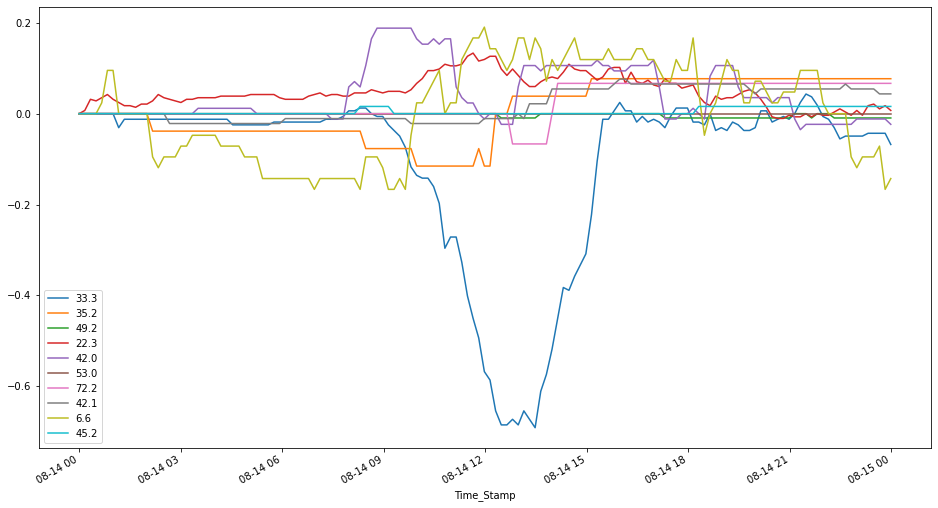

In [606]:
Dock_Normal.sample(10,axis=1).plot(figsize=(16,9))

<AxesSubplot:xlabel='Time_Stamp'>

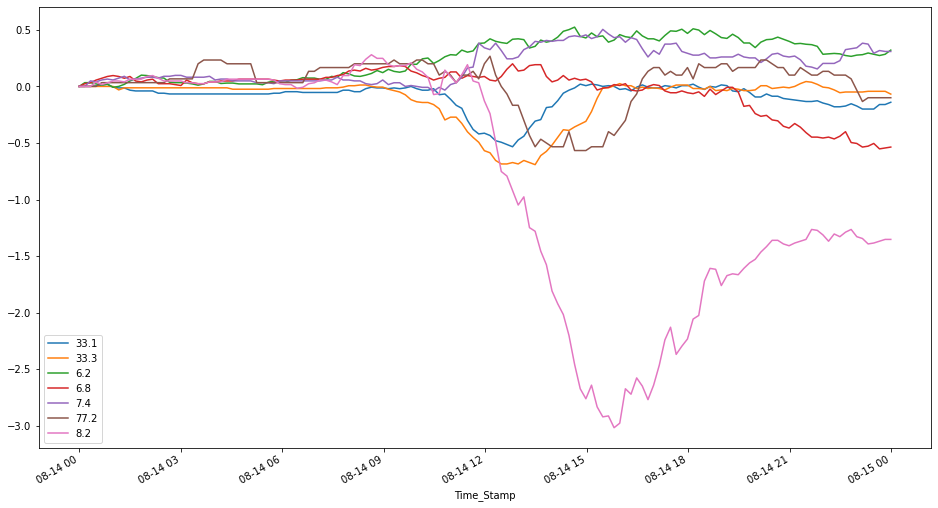

In [607]:
ROI_idx = Dock_Normal.abs().max()[Dock_Normal.abs().max()>0.5].index
Dock_Normal[ROI_idx].plot(figsize=(16,9))

In [628]:
ts = D.time_book[123]

# Run clustering to identify similiar groups

### K-means

In [759]:
temp_T = Dock_Normal.T
kmeans = KMeans(n_clusters=6).fit(temp_T)
labs = kmeans.labels_
temp_T['labels'] = [str(l) for l in labs]
temp_T['labels'].value_counts()

C:\Users\18066\Anaconda3\envs\Divvy\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


0    107
2     32
3     14
5     13
4      4
1      1
Name: labels, dtype: int64

Capacity Trend for cluster 0


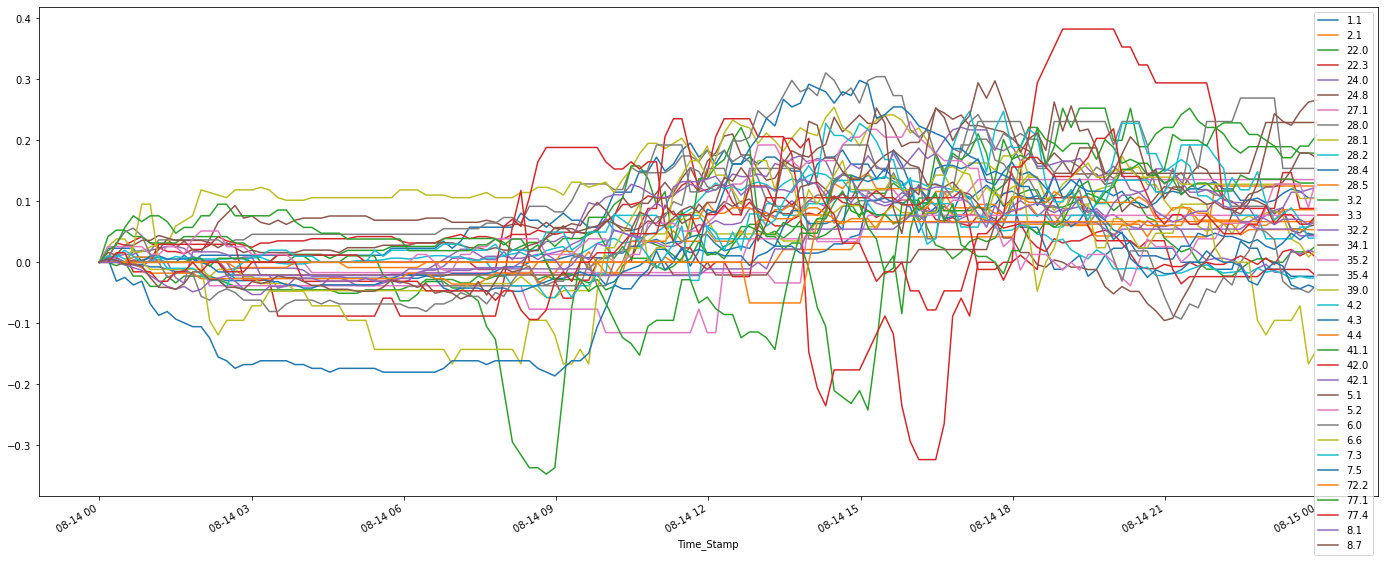

Capacity Trend for cluster 1


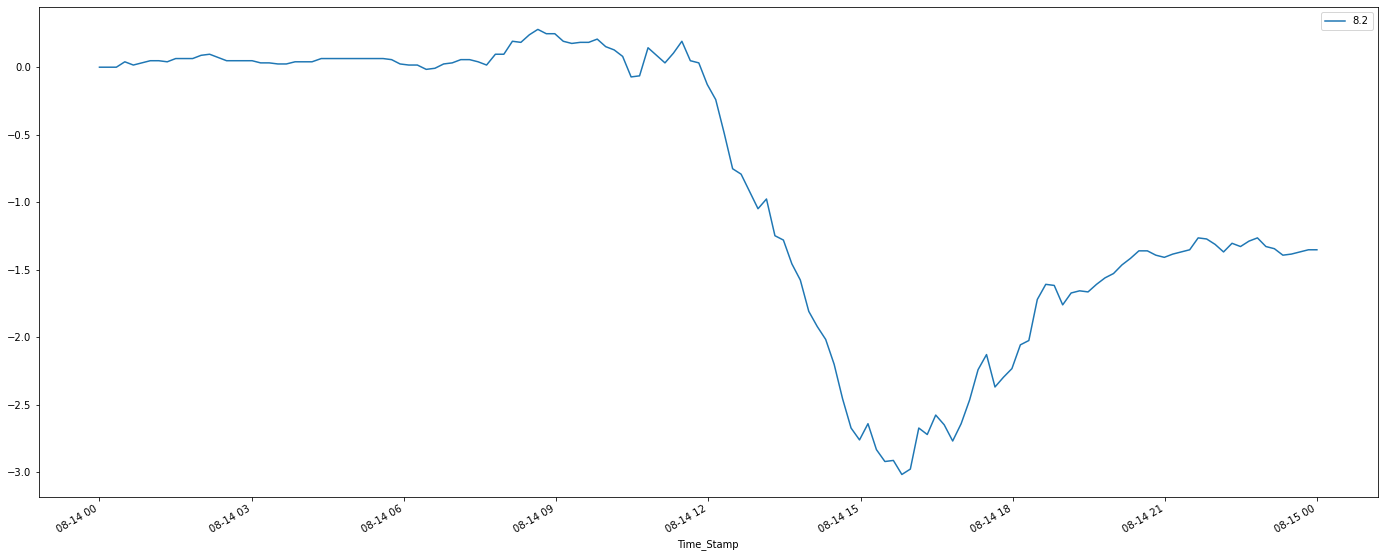

Capacity Trend for cluster 2


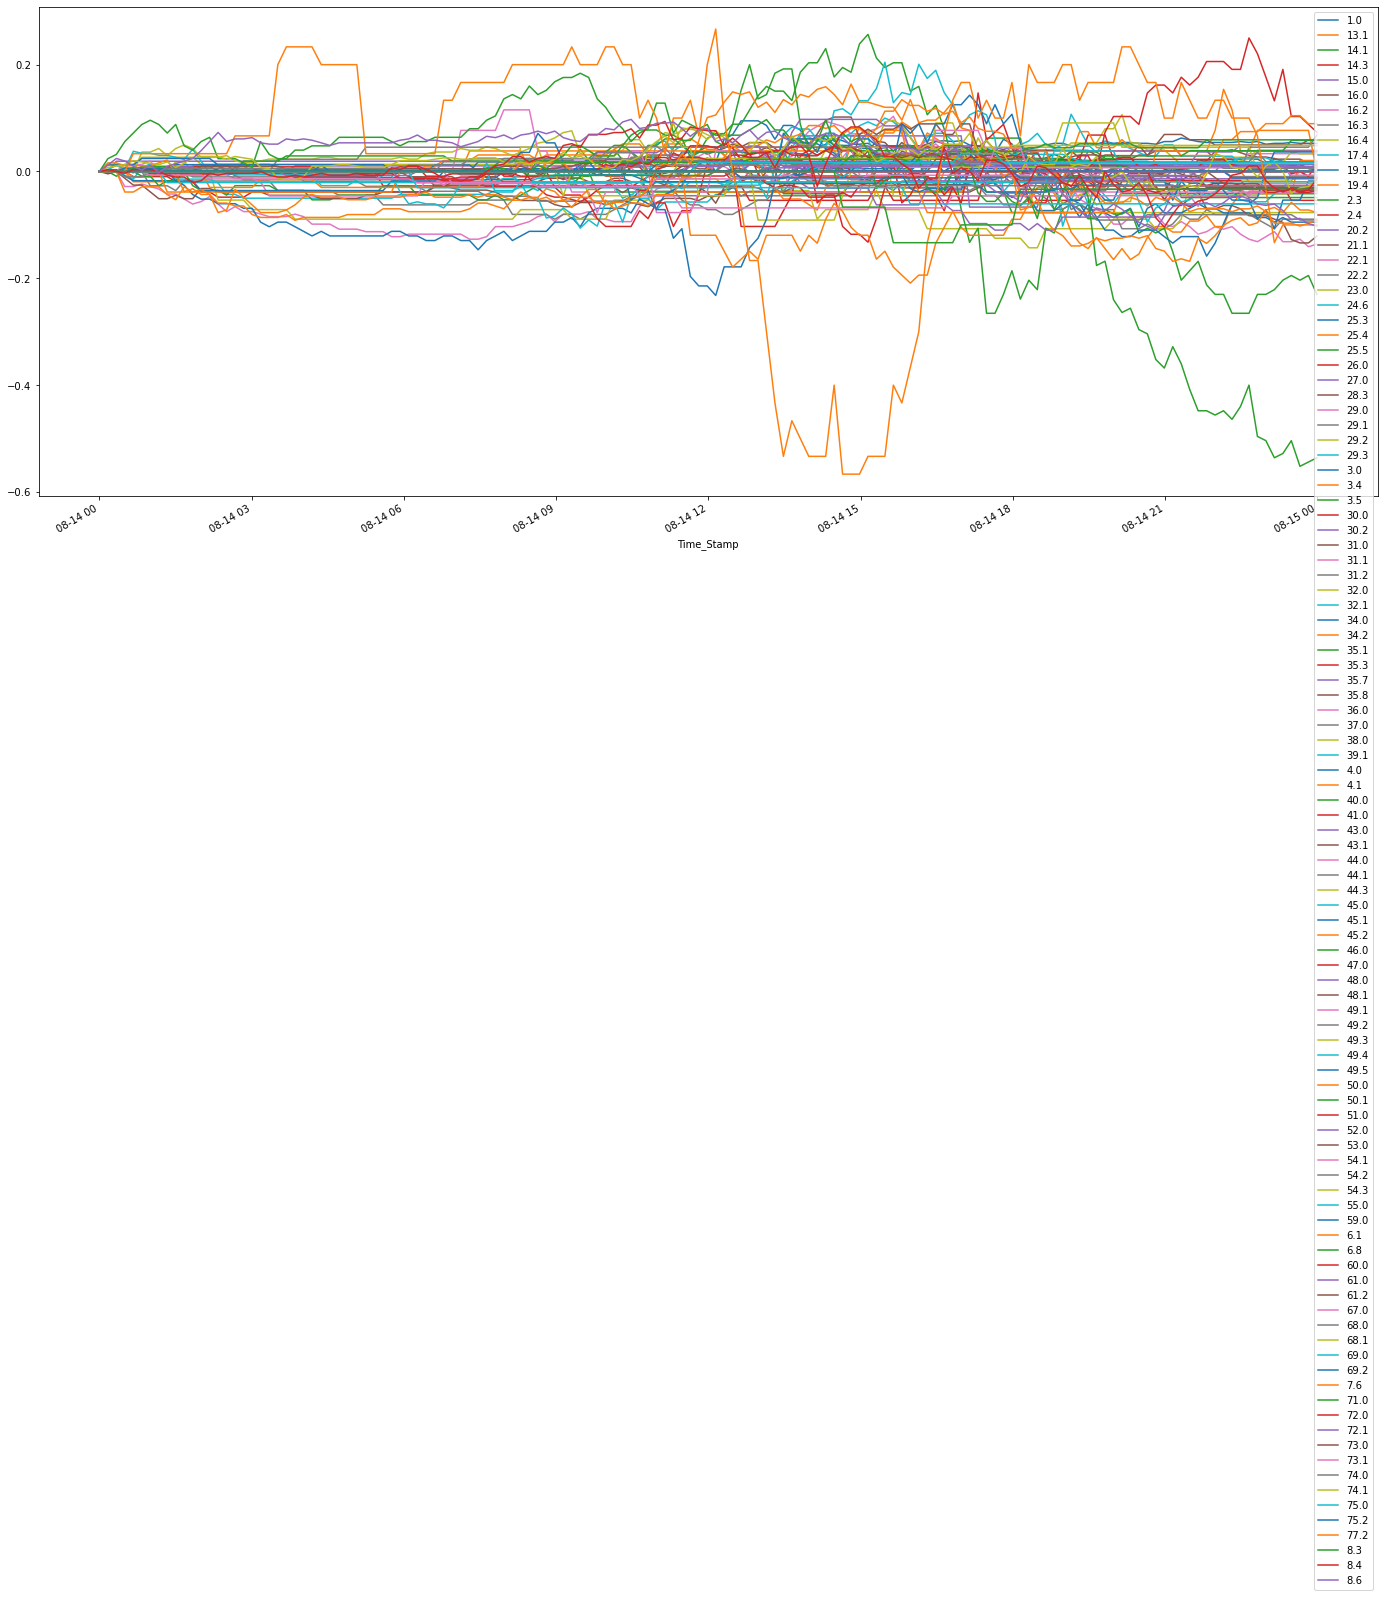

Capacity Trend for cluster 3


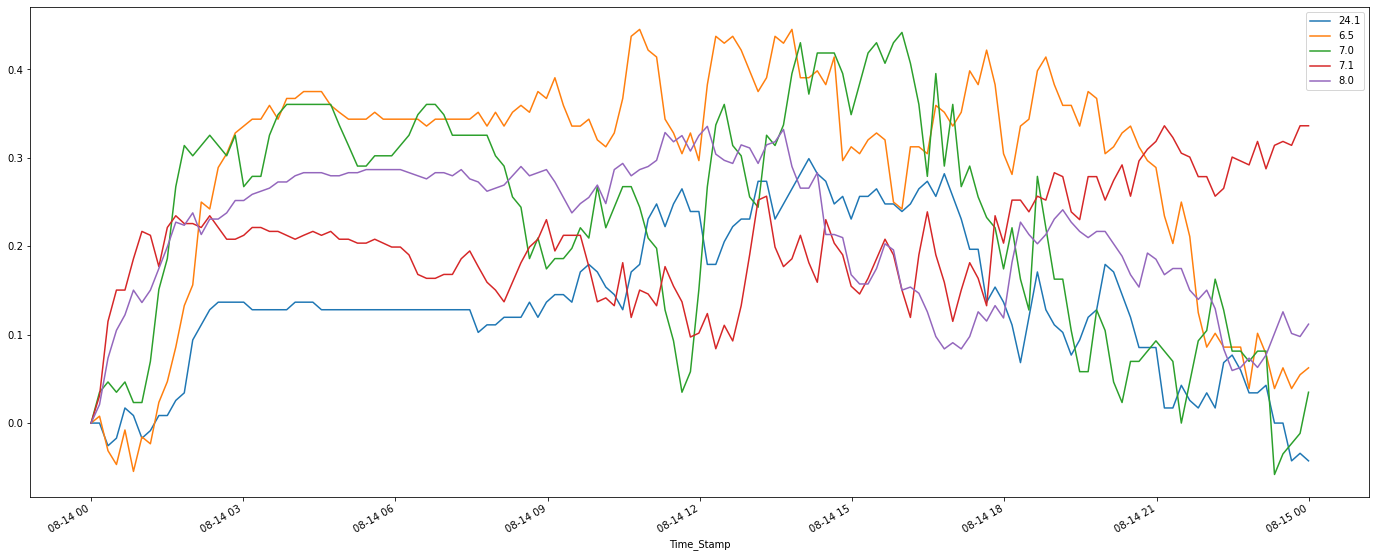

Capacity Trend for cluster 4


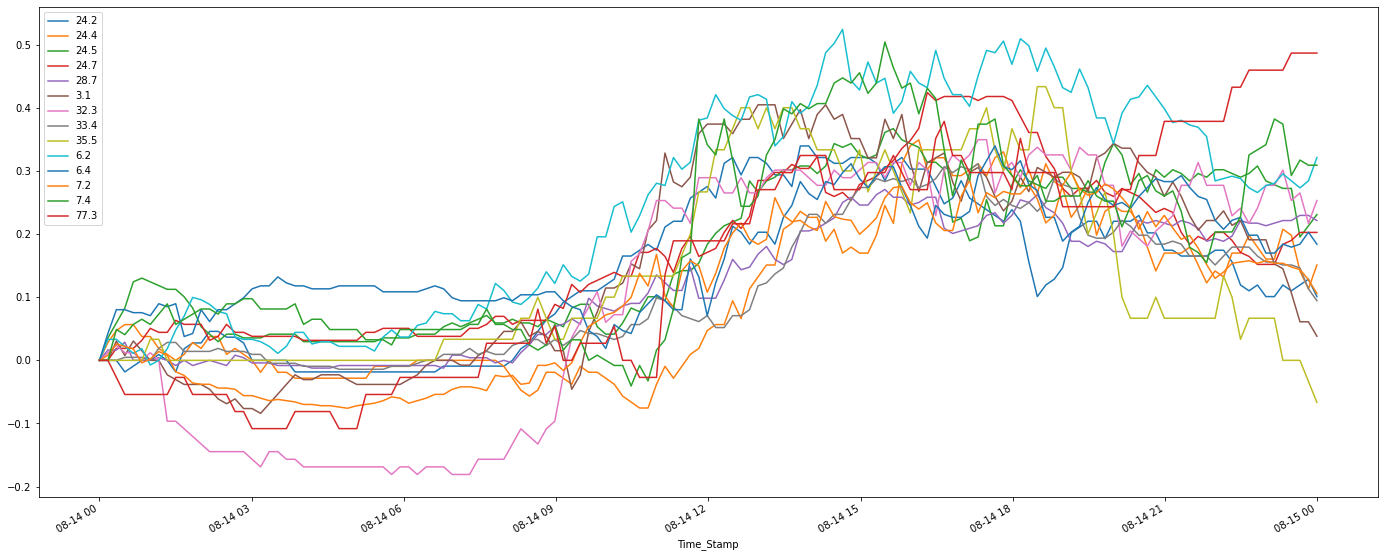

Capacity Trend for cluster 5


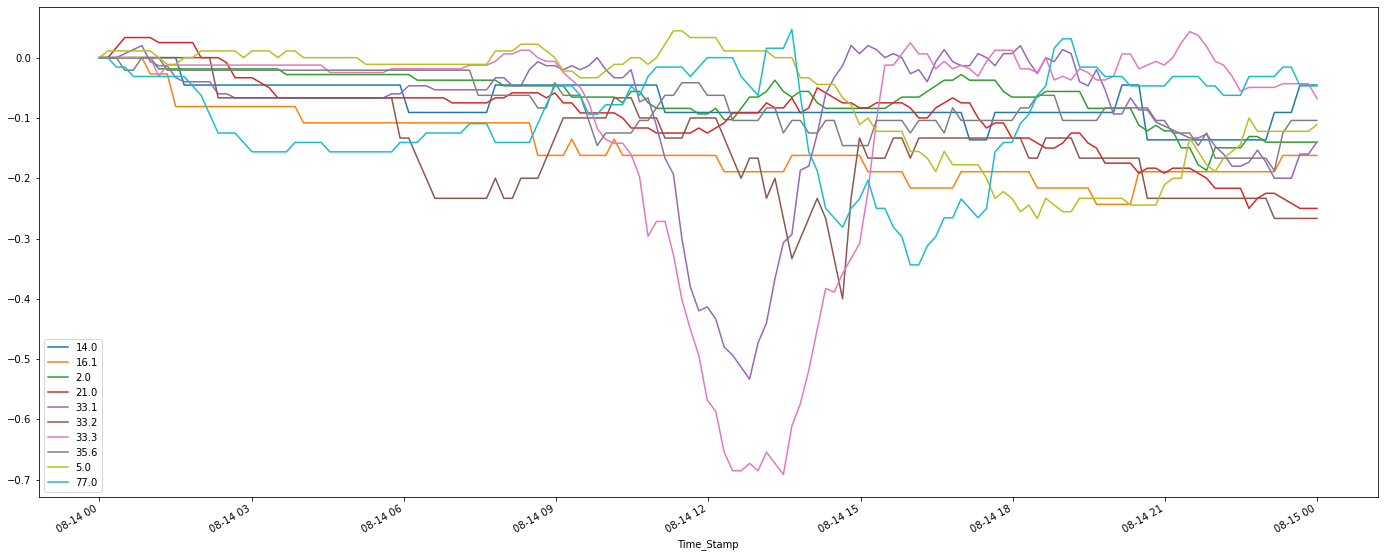

In [708]:
for lab in set(labs):
    print(f"Capacity Trend for cluster {lab}")
    temp_T.query(f'labels == "{lab}"').drop('labels',axis=1).T.plot(figsize=(24,10))
    plt.show()

In [760]:
df_cluster = pd.DataFrame(temp_T['labels']).reset_index().rename(columns={'index':'Nbh_id'})
df_Station_cluster = df_Station_final.merge(df_cluster,left_on='Nbh_id',right_on='Nbh_id')

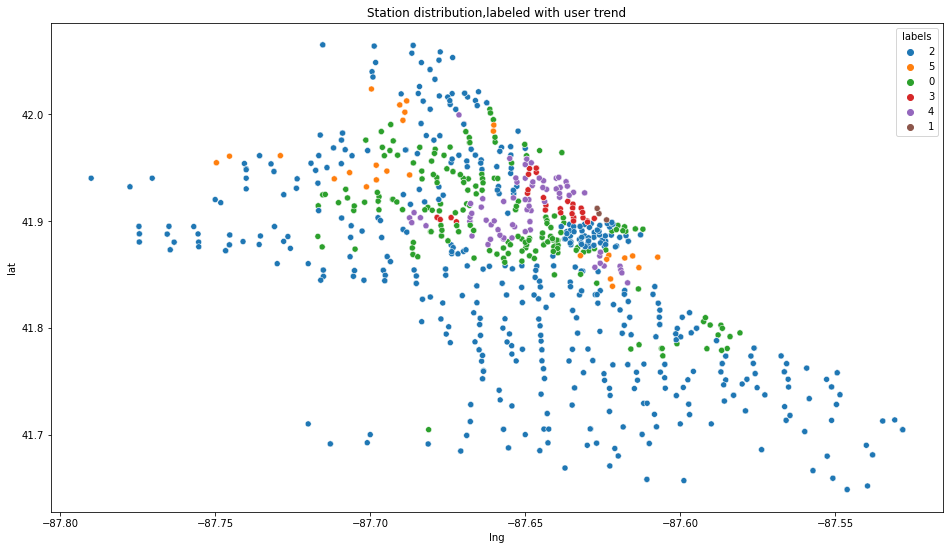

In [710]:
plt.figure(figsize=(16,9))
plt.title('Station distribution,labeled with user trend')
sns.scatterplot(data=df_Station_cluster,x='lng',y='lat',hue='labels')
plt.show()

In [700]:
df_Station_cluster

station_id        lng        lat  \
0             2 -87.620527  41.876503   
1            39 -87.625699  41.879487   
2            43 -87.624667  41.883986   
3            45 -87.624417  41.876218   
4            90 -87.624088  41.881026   
...         ...        ...        ...   
1356      20212 -87.598830  41.656937   
1357        358 -87.740000  41.930000   
1358        360 -87.740000  41.940000   
1359        397 -87.790000  41.940000   
1360        473 -87.770313  41.940000   

                                          cord                   station_name  \
0      (-87.62052684219132, 41.87650284189418)            Buckingham Fountain   
1      (-87.62569931505863, 41.87948739171187)          Wabash Ave & Adams St   
2      (-87.62466675684625, 41.88398618107056)   Michigan Ave & Washington St   
3      (-87.62441718998497, 41.87621829182935)  Michigan Ave & Ida B Wells Dr   
4     (-87.62408845986762, 41.881026207273806)                Millennium Park   
...                                        ...                            ...   
1356   (-87.59882966666669, 41.65693733333332)                Altgeld Gardens   
1357  (-87.73999999999998, 41.929999999999986)    Kilpatrick Ave & Parker Ave   
1358   (-87.73999999999992, 41.94000000000003)              Kilbourn & Roscoe   
1359   (-87.78999999999998, 41.94000000000003)   Narragansett Ave & School St   
1360          (-87.7703125, 41.94000000000003)        Mason Ave & Belmont Ave   

     Nbh_id com_id  Docks in Service  labels  
0      32.0     32              39.0       5  
1      32.0     32              23.0       5  
2      32.0     32              43.0       5  
3      32.0     32              15.0       5  
4      32.0     32              47.0       5  
...     ...    ...               ...     ...  
1356   54.1     54              15.0       5  
1357   20.2     20              15.0       5  
1358   16.2     16              15.0       5  
1359   17.4     17              15.0       5  
1360   15.0     15              15.0       5  

[1361 rows x 9 columns]

# Community Based Clustering

<AxesSubplot:xlabel='Time_Stamp'>

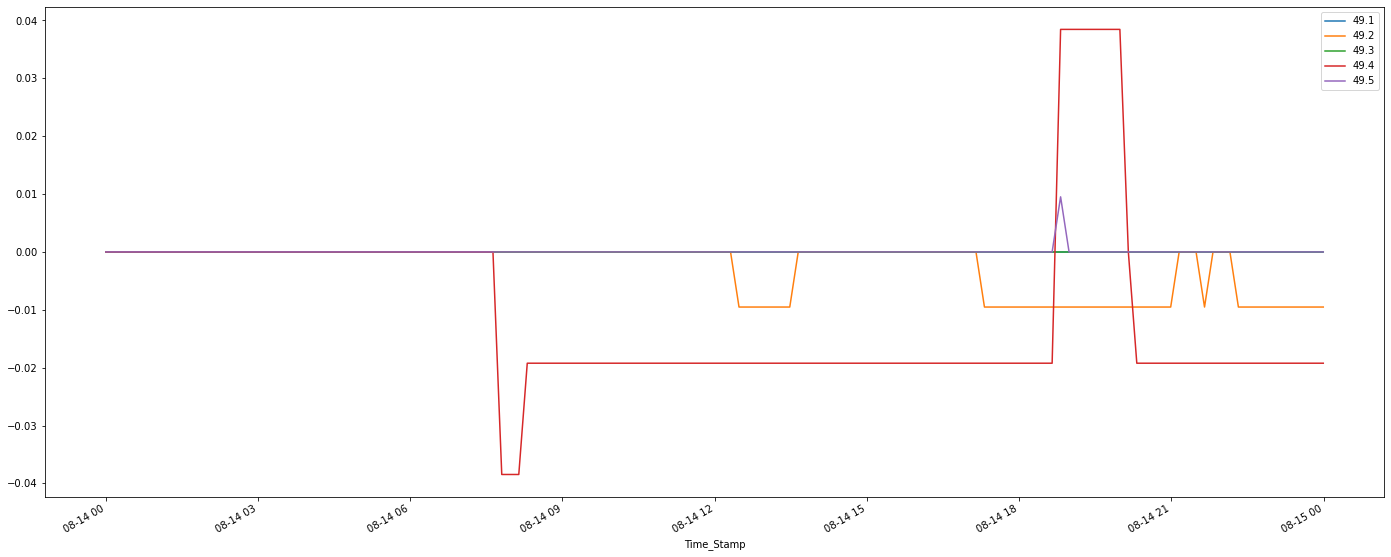

In [714]:
community = 49
temp_T.T[[i for i in temp_T.T.columns if i.split('.')[0] == str(community)]].drop('labels',axis=0).plot(figsize=(24,10))

### DBscan

In [661]:
clustering = DBSCAN(eps=0.5, min_samples=5).fit(temp_T)
labs = clustering.labels_
temp_T['labels'] = labs
temp_T['labels'].value_counts()

C:\Users\18066\Anaconda3\envs\Divvy\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  warnings.warn(


 0    83
-1    59
 1    29
Name: labels, dtype: int64

<AxesSubplot:xlabel='Time_Stamp'>

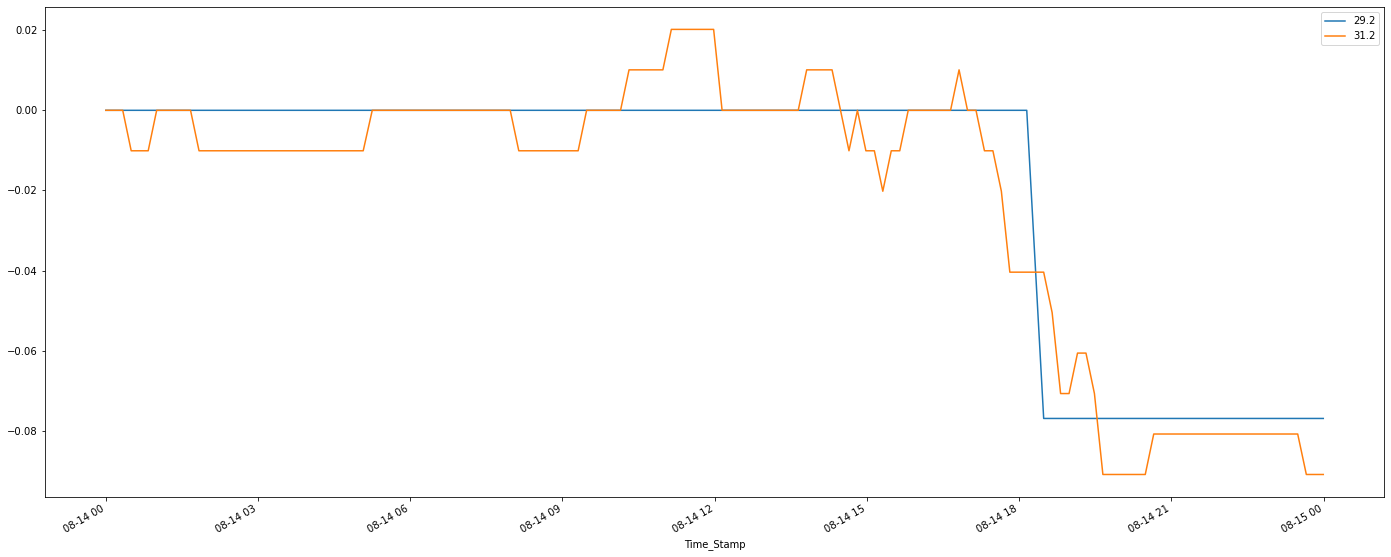

In [655]:
temp_T.query('labels == 3').drop('labels',axis=1).T.plot(figsize=(24,10))

<AxesSubplot:xlabel='Time_Stamp'>

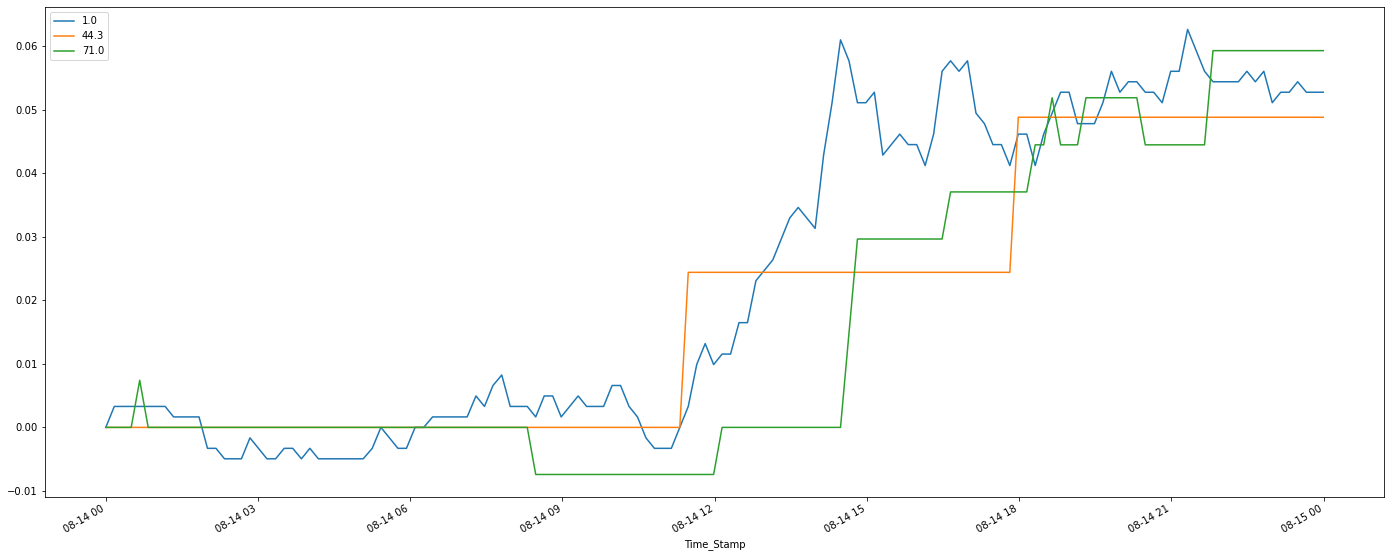

In [646]:
temp_T.query('labels == 1').drop('labels',axis=1).T.plot(figsize=(24,10))

<AxesSubplot:xlabel='Time_Stamp'>

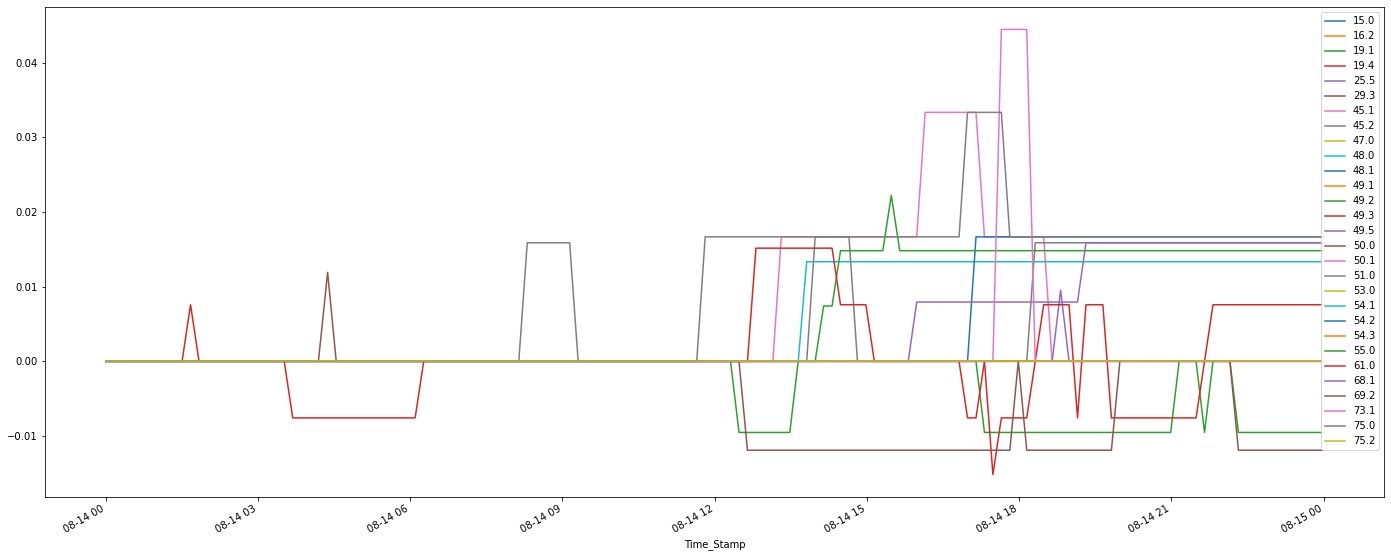

In [662]:
temp_T.query('labels == 1').drop('labels',axis=1).T.plot(figsize=(24,10))

### Ploting based on max-capacity

In [775]:
df_Capacity = pd.DataFrame(Dock_Normal.max())
df_Capacity['daily_capacity_low'] = Dock_Normal.min()
df_Capacity = df_Capacity.reset_index()
df_Capacity = df_Capacity.rename(columns={0: 'daily_capacity_high','index':'Nbh_id'})
df_Capacity['daily_capacity_mean'] = list(Dock_Normal.mean())
df_Capacity['daily_capacity_median'] = list(Dock_Normal.median())

In [777]:
df_Station_cluster_capacity = df_Station_cluster.merge(df_Capacity,left_on='Nbh_id',right_on='Nbh_id')

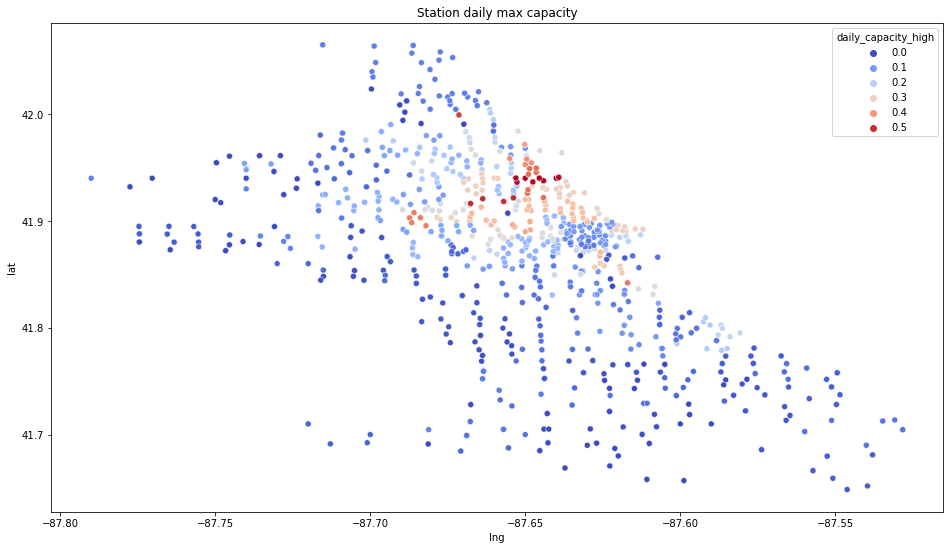

In [778]:
plt.figure(figsize=(16,9))
plt.title('Station daily max capacity')
sns.scatterplot(data=df_Station_cluster_capacity,x='lng',y='lat',hue='daily_capacity_high',
                    palette = 'coolwarm')#,element='labels')

plt.show()

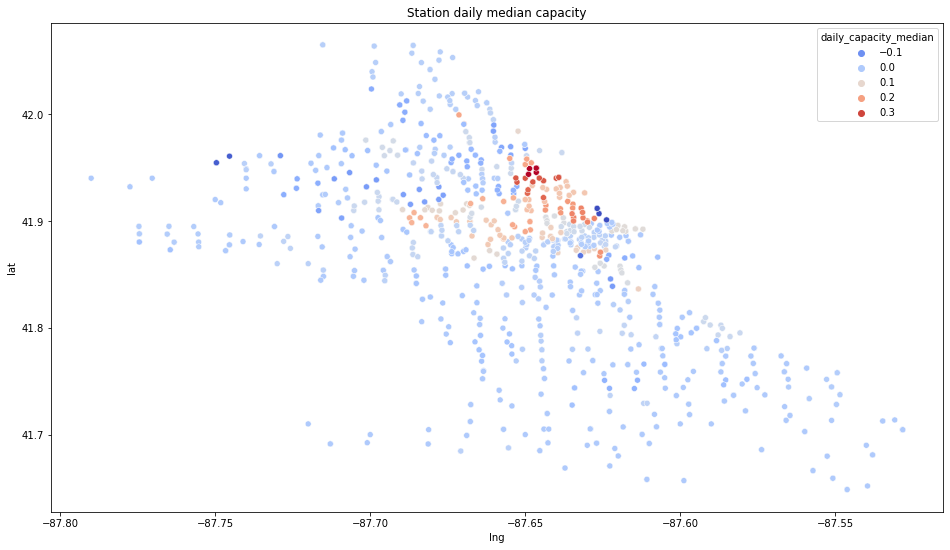

In [782]:
plt.figure(figsize=(16,9))
plt.title('Station daily median capacity')
sns.scatterplot(data=df_Station_cluster_capacity,x='lng',y='lat',hue='daily_capacity_median',
                    palette = 'coolwarm')#,element='labels')

plt.show()

### Visualizing the details

In [785]:
Idx_l0 = df_Station_cluster_capacity.query('daily_capacity_mean>0.1').index

Int64Index([ 118,  119,  120,  121,  122,  123,  124,  125,  126,  127,
            ...
             841,  842,  843,  844,  845,  846,  847, 1059, 1060, 1061],
           dtype='int64', length=233)

<AxesSubplot:>

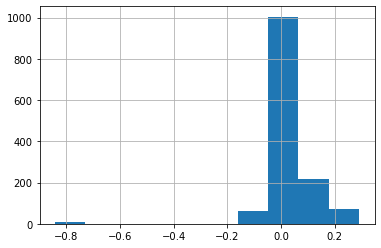

In [791]:
df_Station_cluster_capacity['daily_capacity_mean'].hist()

In [878]:
df_Station_cluster_capacity.query('daily_capacity_low > -2').query(
                    f'daily_capacity_group_mean == "{r}"')['Nbh_id'].unique()

array([], dtype=object)

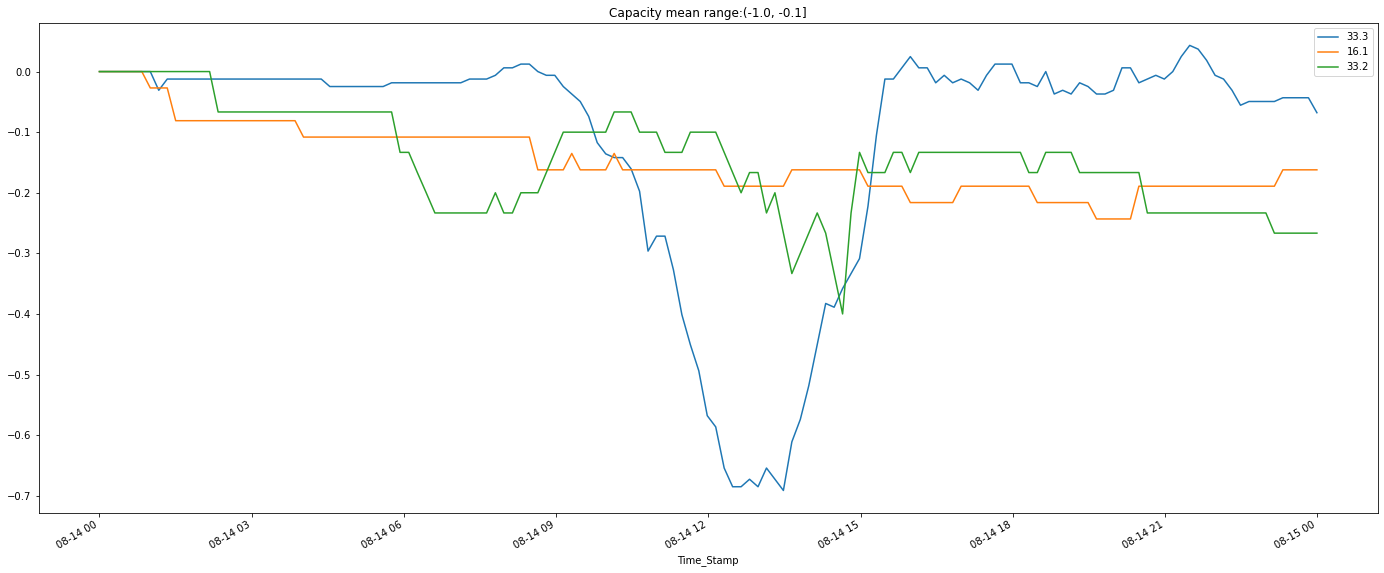

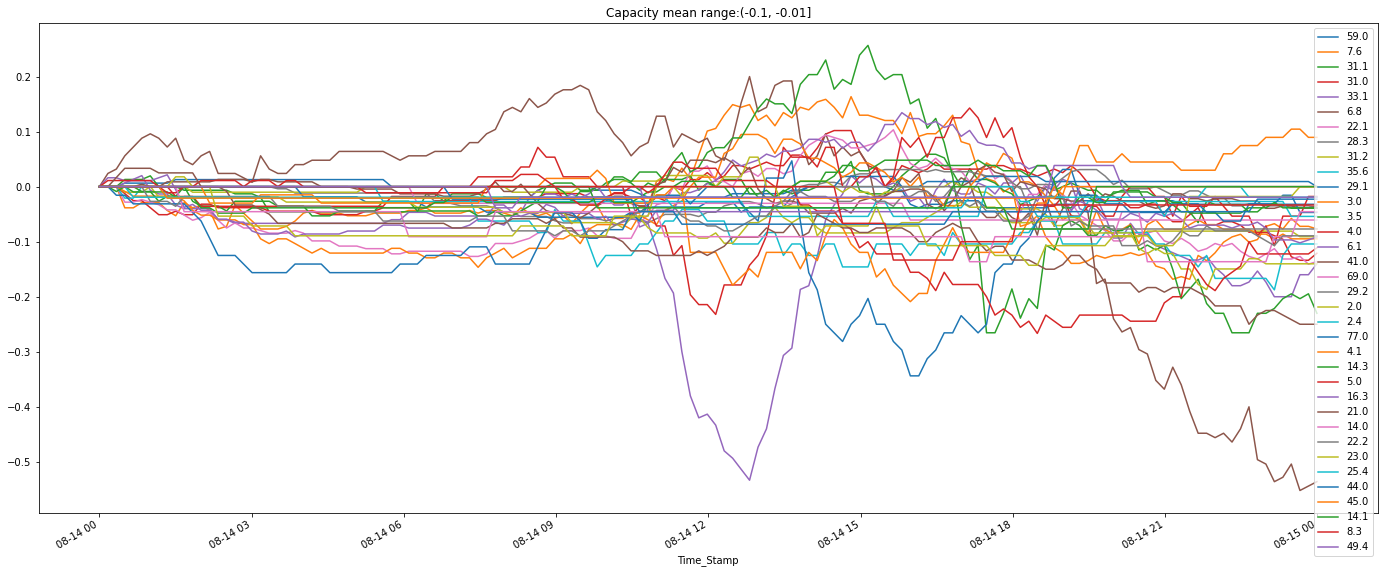

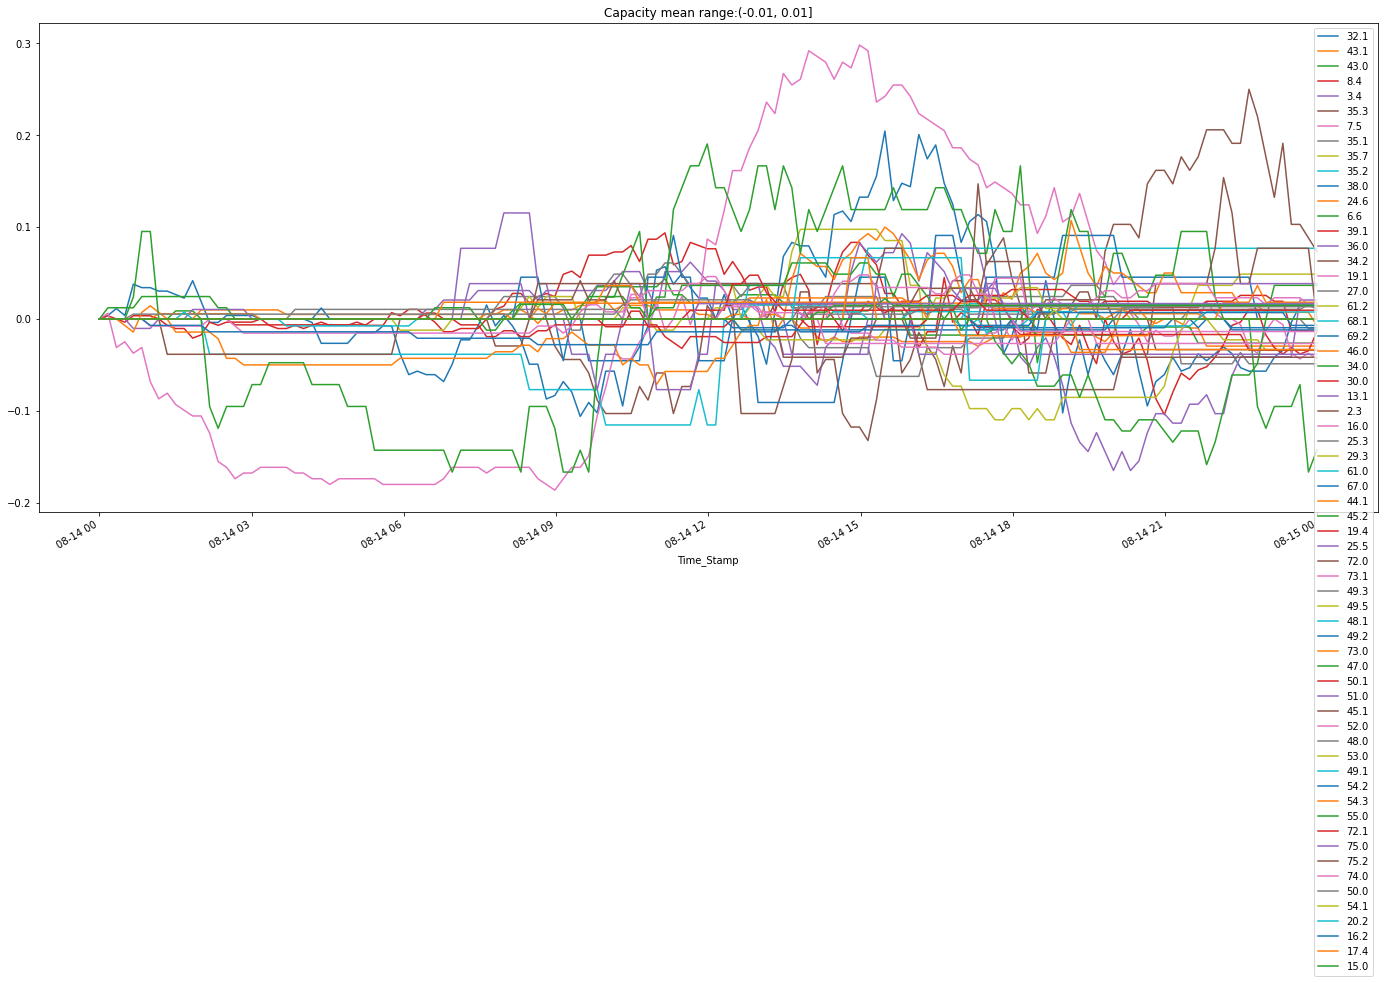

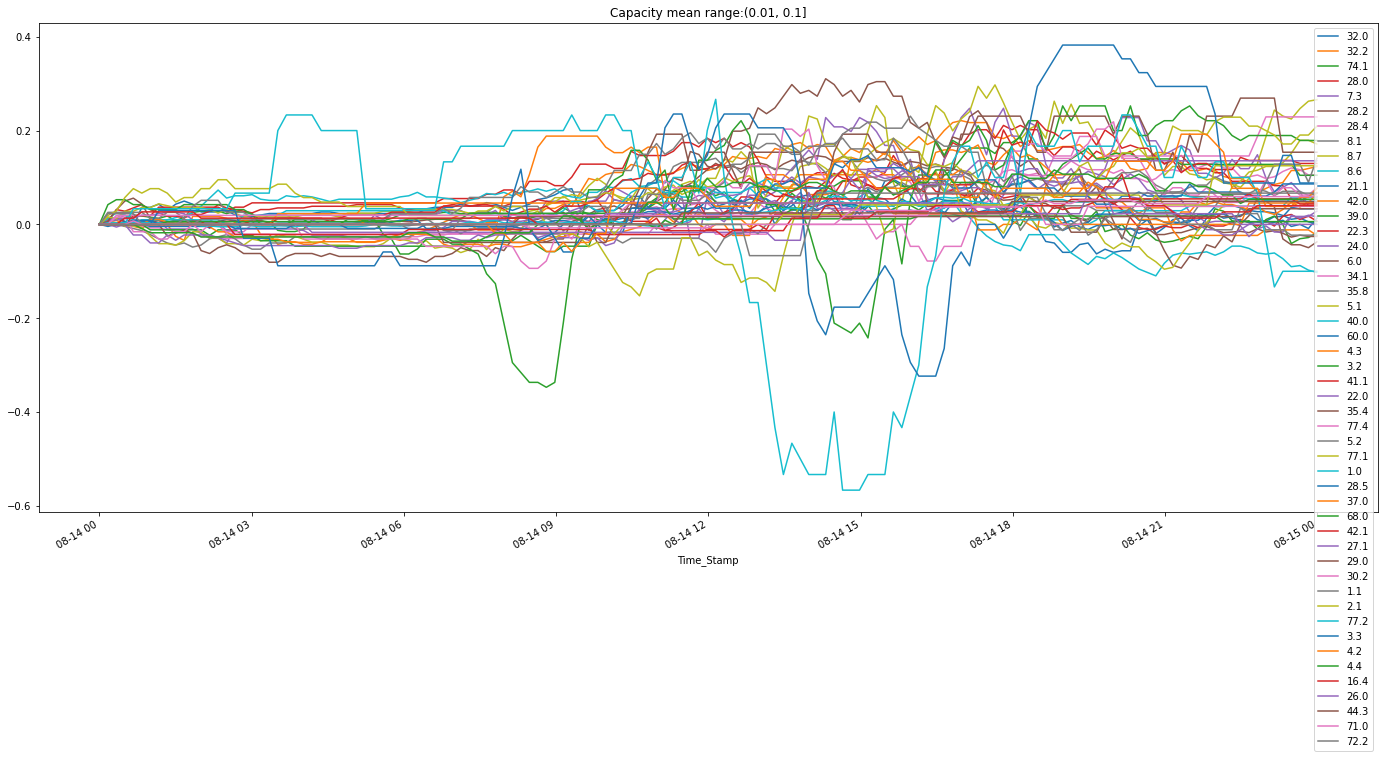

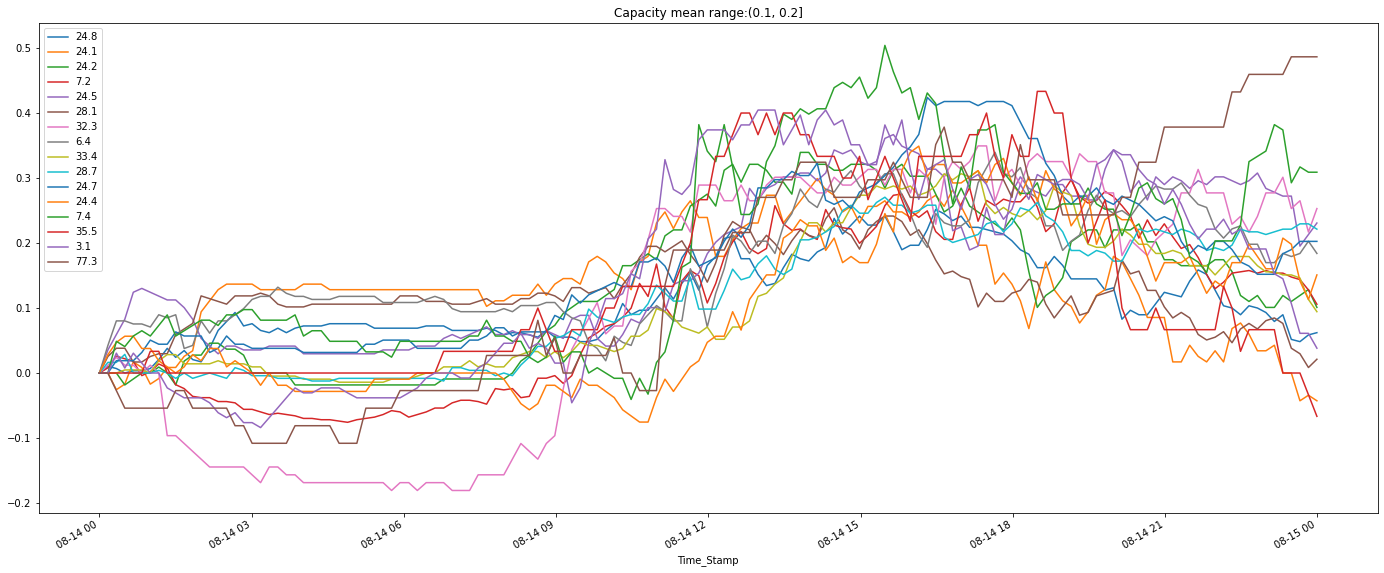

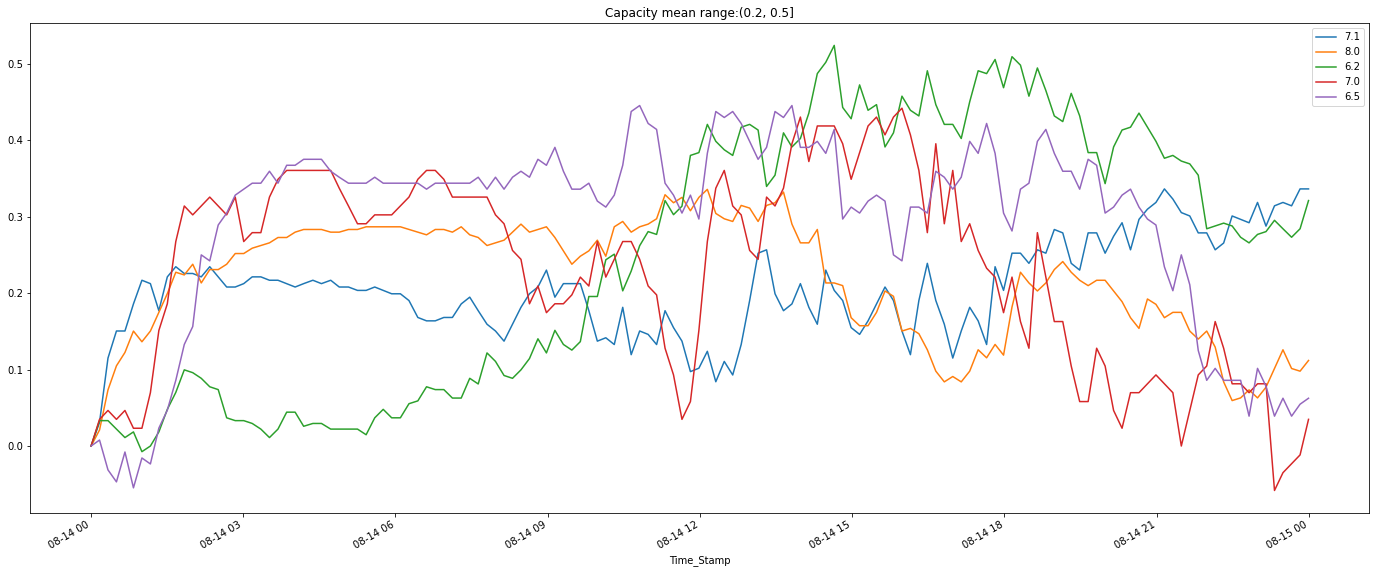

In [893]:
df_Station_cluster_capacity['daily_capacity_group_mean'] = pd.cut(   
        x=df_Station_cluster_capacity['daily_capacity_mean'],bins=[-1,-0.1,-0.01,0.01,0.1,0.2,0.5])#,
        #labels=LABs)

LABs = [str(i) for i in sorted(df_Station_cluster_capacity.daily_capacity_group_mean.unique())]
df_Station_cluster_capacity['daily_capacity_group_mean_str'] = [str(i) for i in df_Station_cluster_capacity.daily_capacity_group_mean]
Index_capacity = {}
for r in LABs:
    Index_capacity[r] = df_Station_cluster_capacity.query('daily_capacity_low > -2').query(
                    f'daily_capacity_group_mean_str == "{r}"')['Nbh_id'].unique()
for r in  LABs:
    temp_T.loc[Index_capacity[r]].drop('labels',axis=1).T.plot(figsize=(24,10))
    plt.title(f'Capacity mean range:{r}')

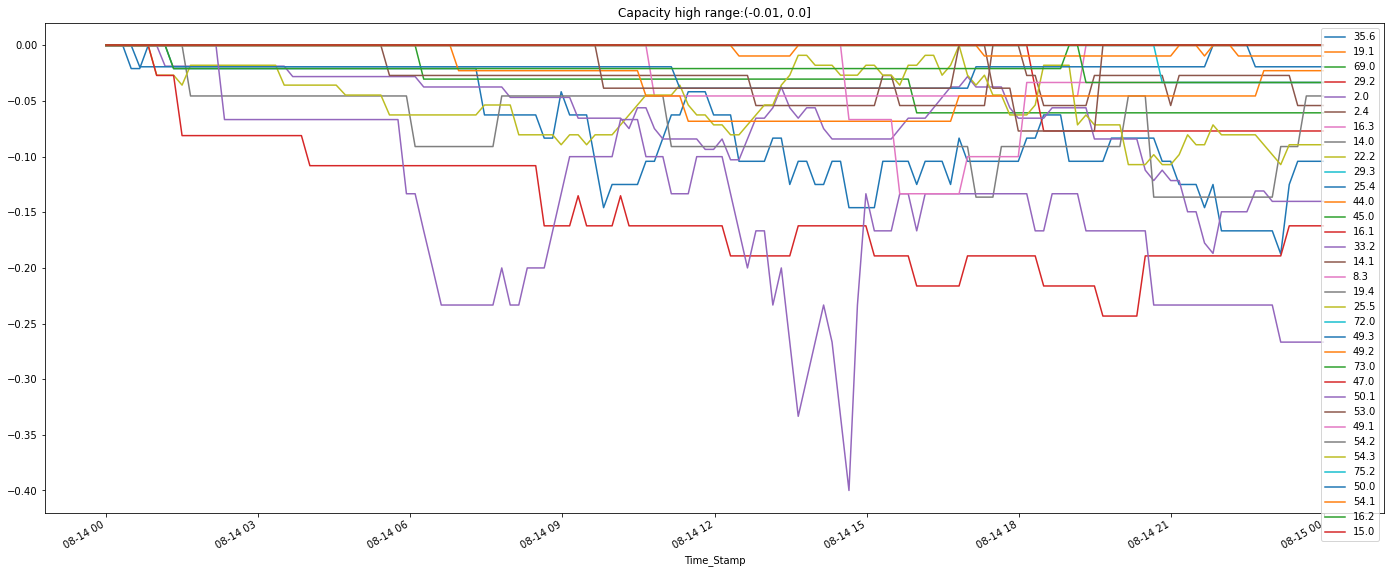

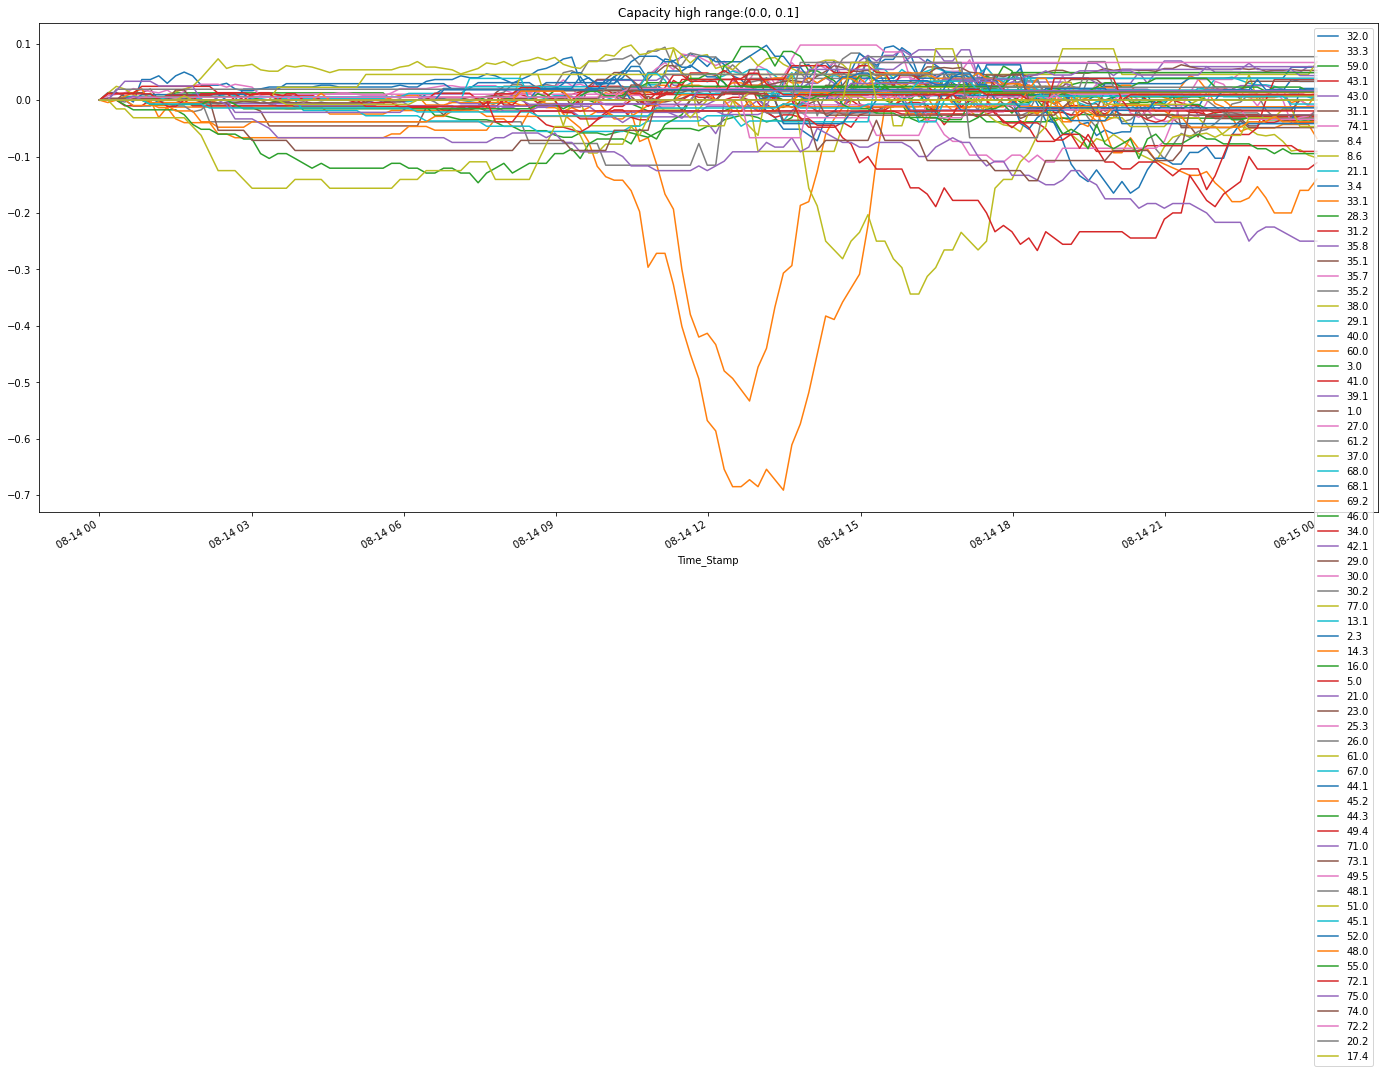

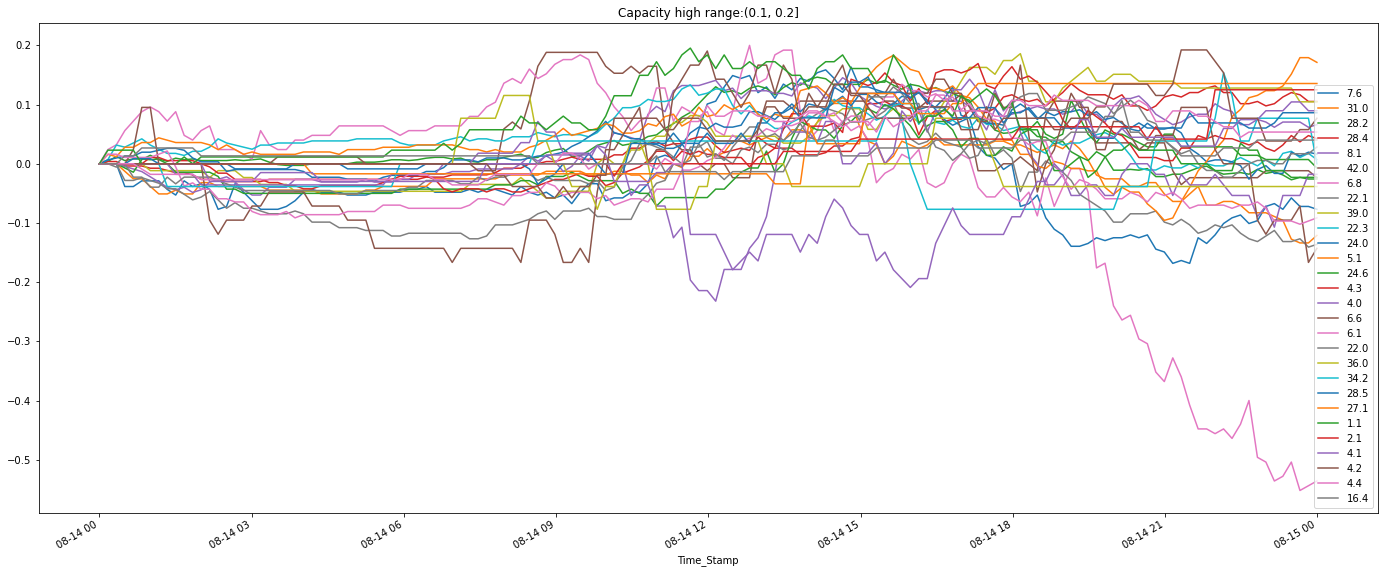

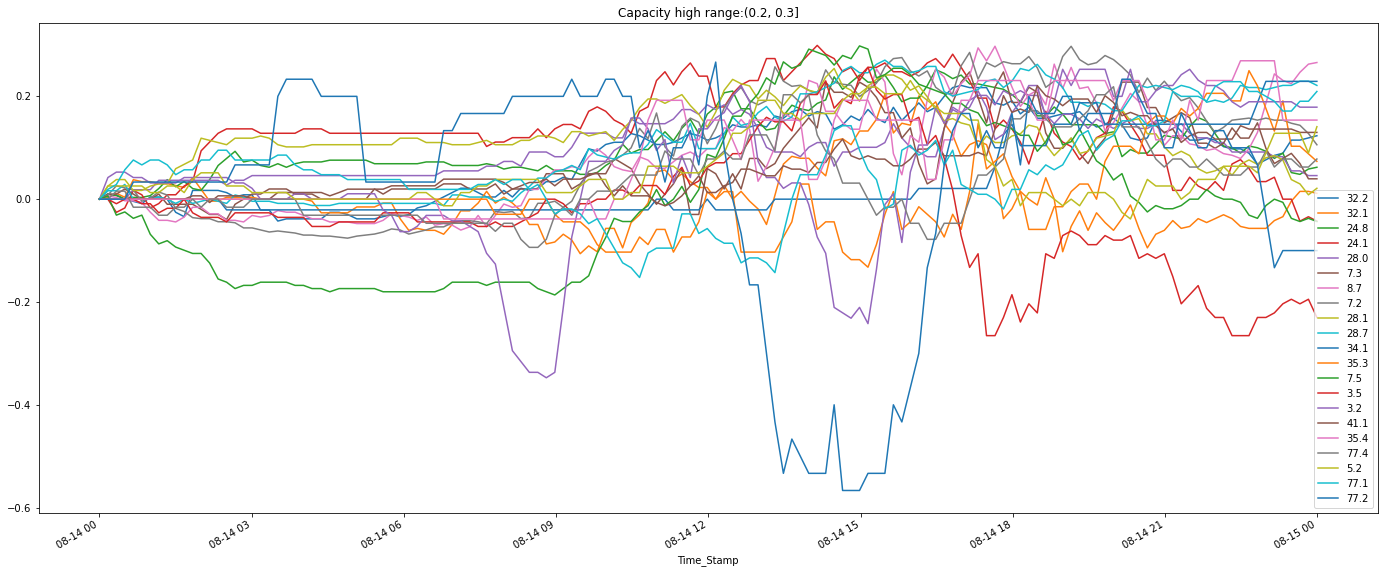

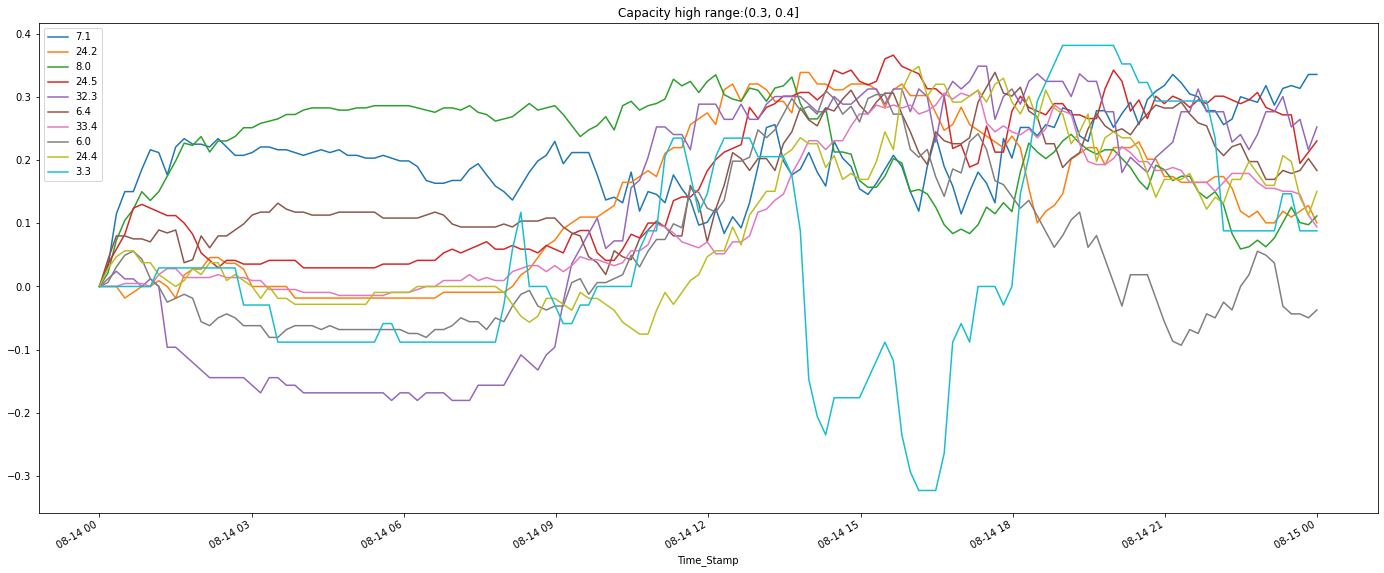

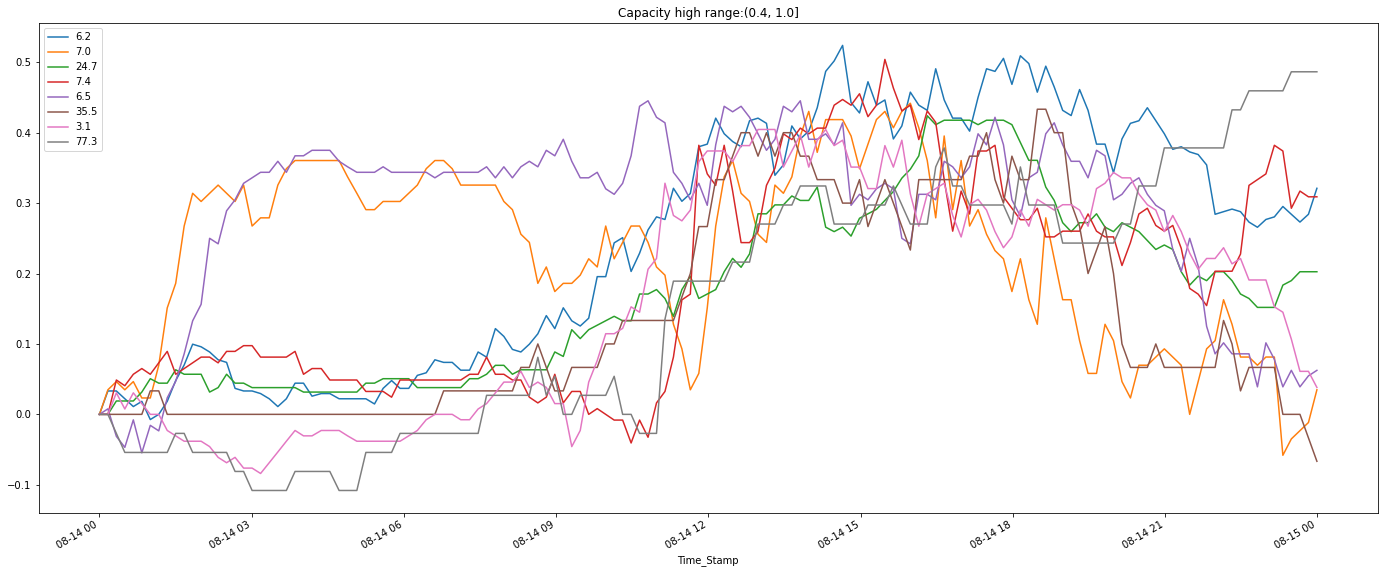

In [907]:
#LABs = ['(0,0.1]','(0.1,0.2]','(0.2,0.3]','(0.3,0.4]','(0.4,1]']
df_Station_cluster_capacity['daily_capacity_group_high'] = pd.cut(   
        x=df_Station_cluster_capacity['daily_capacity_high'],bins=[-0.01,0,0.1,0.2,0.3,0.4,1])
Index_capacity = {}
LABs = [str(i) for i in sorted(df_Station_cluster_capacity.daily_capacity_group_high.unique())]
df_Station_cluster_capacity['daily_capacity_group_high_str'] = [str(i) for i in df_Station_cluster_capacity.daily_capacity_group_high]

for r in LABs:
    Index_capacity[r] = df_Station_cluster_capacity.query('daily_capacity_low > -1').query(
                    f'daily_capacity_group_high_str == "{r}"')['Nbh_id'].unique()
for r in  LABs:
    temp_T.loc[Index_capacity[r]].drop('labels',axis=1).T.plot(figsize=(24,10))
    plt.title(f'Capacity high range:{r}')

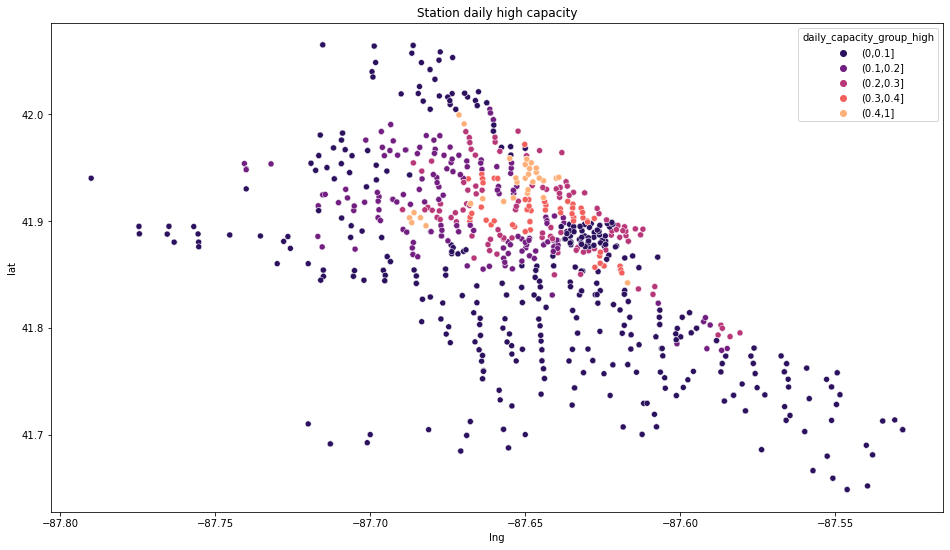

In [896]:
plt.figure(figsize=(16,9))
plt.title('Station daily high capacity')
sns.scatterplot(data=df_Station_cluster_capacity,x='lng',y='lat',hue='daily_capacity_group_high',
                    palette = 'magma')#,element='labels')

plt.show()

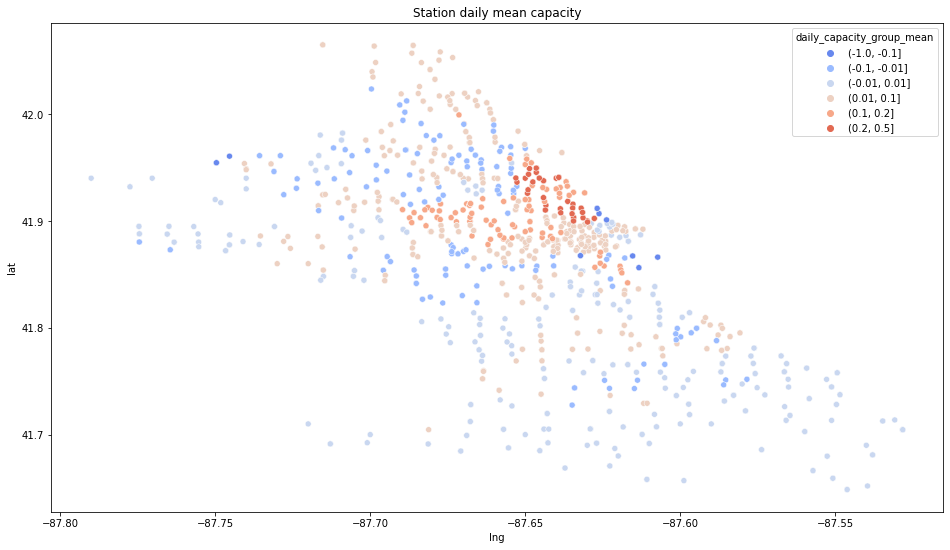

In [895]:
plt.figure(figsize=(16,9))
plt.title('Station daily mean capacity')
sns.scatterplot(data=df_Station_cluster_capacity,x='lng',y='lat',hue='daily_capacity_group_mean',
                    palette = 'coolwarm')#,element='labels')

plt.show()